#Laborator 4

In cadrul acestui laborator o sa lucram cu blocurile de baza necesare construirii unor retele mai complexe. De interes sunt:


*   Residual Blocks
*   Inception Blocks

Pe langa acestea, o sa aplicam si augmentari generale de date care au rolul de a face modelul robust la variatii mici. 



## Operatii Noi

Urmatoarele operatii vor fi folosite in cadrul laboratorului

Tensor shape: (batch,channels,dim1,dim2)


*  **torch.cat(tensors, dim=0).** Tensorii trebuie sa aiba aceleasi dim1,dim2, dar channels poate sa difere.
*  **torch.add(input, other)**. Tensorii trebuie sa aiba aceleasi dimensiune pe toate axele.





In [1]:
import torch.utils.data as data
import torch.optim as optim
from IPython.display import clear_output
import time
import glob
import torch.nn as nn
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random, os
import matplotlib.pyplot as plt
import torchvision.models as models
from pytorch_model_summary import summary

In [ ]:

dummy_input_tensor1 = torch.rand((1, 3, 100, 100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1, 5, 100, 100))  # Input random de marime 100x100 cu 5 canale

# Normal se concateneaza pe dimensiunea canalelor.
x = torch.cat([dummy_input_tensor1, dummy_input_tensor2], dim=1)
print(x.shape)  # Numarul de canele_output = canale_input2 + canale_input1

dummy_input_tensor1 = torch.rand((1, 3, 100, 100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1, 3, 100, 100))  # Input random de marime 100x100 cu 3 canale

x = torch.add(dummy_input_tensor1, dummy_input_tensor2)
print(x.shape)

##Residual Block

In cadrul Resnet se utilizeaza residual connections / skip connections, care impreuna cu un path normal, ca cele implementate pana acum, formeaza un residual block. 

<img src="https://user-images.githubusercontent.com/6086781/28494249-97e81166-6ef6-11e7-88b8-fa4aa184bc0b.png" alt="Drawing" style="height: 400px;"/>


###Cerinta 1 - **(3p)**

Implementati ResidualBlock. Acesta duce input tensor din ($c_{input}$,width,height) in  ($c_{out}$,width,height) sau  ($c_{out}$,width/2,height/2) in functie de stride. (Puteti implemnta oricare dintre variantele din imagine)




In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, input_channels=32, hidden_channels=64, output_channels=64, kernel_size=3, stride=1,
                 activation=nn.ReLU()):
        super(ResidualBlock, self).__init__()
        layers = [

        ]

        # Your code here
        self.net_normal = nn.Sequential(*layers)

        self.net_residual = nn.Conv2d(input_channels, output_channels, 1, stride)

    def forward(self, x):
        x = torch.add(self.net_normal(x), self.net_residual(x))
        x = F.relu(x)
        return x


block = ResidualBlock(3, 64, 128, 3, 2, nn.ReLU())
x = torch.rand(size=(1, 3, 100, 100))

# Should output torch.Size([1, 128, 50, 50])
print(block(x).shape)

##Inception Block

In cadrul GoogleNet/InceptionNet este folosit Inception Block, care este alcatuit din mai multe mini-retele putin diferite, care se unesc la finalul Inception Block

### Cerinta 2 - **(3p)**

Implementati Inception Block. Acesta trebuie sa duca un Tensor ($ch_{input}$,w,h) in ($ch_{out}$,w/2,h/2)

Punctaj:
- cate **0.5p** pentru fiecare path implementat corect **(4 * 0.5p = 2p)**
- codul ruleaza si rezultatul final este corect (**1p**)


<!-- ![InceptionBlock](https://drive.google.com/uc?export=view&id=11eiInGoQoytm_N0989v5oJnKpFrspUzk) -->

<img src="https://drive.google.com/uc?export=view&id=11eiInGoQoytm_N0989v5oJnKpFrspUzk" alt="Drawing" style="height: 200px; width:200px;"/>

In [ ]:



class InceptionBlock(nn.Module):
    def __init__(self, input_channels=3, output_channels=256, kernel_size=3, stride=1, activation=nn.ReLU()):
        super(InceptionBlock, self).__init__()
        #  3, 100, 100 -> 
        conv_block1 = self.conv_block(in_channels=input_channels, out_channels=input_channels * 2, kernel=1, stride=1, padding=0, activation=activation)
        conv_block2 = self.conv_block(in_channels=input_channels * 2, out_channels=input_channels * 2 * 2, kernel=3, stride=1, padding=1, activation=activation)
        conv_block3 = self.conv_block(in_channels=input_channels * 2 * 2, out_channels=64, kernel=3, stride=2, padding=1, activation=activation)
        layers = conv_block1 + conv_block2 + conv_block3
        self.path1 = nn.Sequential(*layers)

        conv_block1 = self.conv_block(in_channels=input_channels, out_channels=input_channels * 4, kernel=1, stride=1, padding=0, activation=activation)
        conv_block2 = self.conv_block(in_channels=input_channels * 4, out_channels= 64, kernel=3, stride=2, padding=1, activation=activation)
        layers = conv_block1 + conv_block2
        self.path2 = nn.Sequential(*layers)
        
        layers = [nn.MaxPool2d(kernel_size=2)]
        conv_block1 = self.conv_block(in_channels=input_channels, out_channels=64, kernel=1, stride=1, padding=0, activation=activation)
        layers += conv_block1
        self.path3 = nn.Sequential(*layers)
            

        layers = []
        conv_block1 = self.conv_block(in_channels=input_channels, out_channels=64, kernel=1, stride=2, padding=0, activation=activation)
        layers += conv_block1
        self.path4 = nn.Sequential(*layers)


    def forward(self, x):
        x1 = self.path1(x)
        print(x1.shape)
        x2 = self.path2(x)
        print(x2.shape)
        x3 = self.path3(x)
        print(x3.shape)
        x4 = self.path4(x)
        print(x4.shape)
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

    def conv_block(self, in_channels, out_channels, kernel, stride, padding, activation):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            activation
        ]
        return layers


block = InceptionBlock()
x = torch.rand(size=(1, 3, 100, 100))

# Should output torch.Size([1, 256, 50, 50])
print(block(x).shape)

## Instantierea seturilor de date

In acest laborator lucram cu un nou set de date. Este vorba de un dataset folosit in [aceasta competitie Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview), Pisici vs Caini. 

***In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.***


# Descarcarea setului de date

### Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~ /.kaggle/ & & mv kaggle.json ~ /.kaggle/ & & chmod 600 ~ /.kaggle/kaggle.json

In [ ]:
!pip install kaggle
!kaggle competitions download -c dogs-vs-cats
! for z in *.zip; do unzip "$z"; done
!ls

## Crearea Dataloader-ului

In continuare, pentru a incarca date, sa o folosim un obiect mai complex, un Torch.utils.data.Dataset. Acesta are 3 functii importante:


*   __init__()
*   ____len____()
*  ____get_item____()



In [3]:
# random.seed(42)

train_dir = 'dog-vs-cats/train'
test_dir = 'dog-vs-cats/test1'

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, width=128, height=128, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.img_size = (width, height)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        original_width, original_height = self.img_size

        img = img.resize(self.img_size)
        img = np.array(img)

        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return to_tensor(img), label

Construire Dataset si vizualizare date.

In [ ]:
train_test_proportion = .85

samples = glob.glob(os.path.join('./dog-vs-cats/train', '*.jpg'))

train_samples = samples[:int(train_test_proportion * len(samples))]
test_samples = samples[int(train_test_proportion * len(samples)):]

cats_dogs_train = CatsDogsDataset(train_samples)
cats_dogs_test = CatsDogsDataset(test_samples)

print(cats_dogs_train[0])

train_loader = DataLoader(cats_dogs_train, batch_size=16, shuffle=True)
test_loader = DataLoader(cats_dogs_test, batch_size=16, shuffle=False)


see_examples = 10
for i, (imgs, label) in enumerate(train_loader):
    clear_output(wait=True)
    image = imgs[0].numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.text(5, 15, "DOG" if label[0] else "CAT", fontsize='xx-large', color='red', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
        break
    time.sleep(1)


### Cerinta 3 - **(4p)**

  1. Antrenati o retea convolutionala (o arhitectura la alegere din laboratorul 3) folosind acest dataset, pe GPU (https://pytorch.org/docs/stable/notes/cuda.html) **(1p)**
  2. Antrenati o retea de tip Resnet (folosind blocuri de tip Residual) **(1p)**
  3. Antrenati o retea de tip Inception (folosind blocuri de tip Inception)  **(1p)**
  4. Experimentati cu diferiti hyperparameters (numarul de layers, numarul de filtre/neuroni, etc.) **(1p)**


In [ ]:
train_test_proportion = .85

samples = glob.glob(os.path.join('./dog-vs-cats/train', '*.jpg'))

train_samples = samples[:int(train_test_proportion * len(samples))]
test_samples = samples[int(train_test_proportion * len(samples)):]

cats_dogs_train = CatsDogsDataset(train_samples, width=32, height=32)
cats_dogs_test = CatsDogsDataset(test_samples, width=32, height=32)

print(cats_dogs_train[0][0].shape)

train_loader_lenet = DataLoader(cats_dogs_train, batch_size=16, shuffle=True)
test_loader_lenet = DataLoader(cats_dogs_test, batch_size=16, shuffle=False)

print(next(iter(train_loader_lenet)))

see_examples = 10
for i, (imgs, label) in enumerate(train_loader_lenet):
    clear_output(wait=True)
    image = imgs[0].numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.text(5, 15, "DOG" if label[0] else "CAT", fontsize='xx-large', color='red', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
        break
    time.sleep(1)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=1)
        
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.bn2 = nn.BatchNorm2d(num_features=16)
                
        self.activation1 = nn.Tanh()
        self.activation2 = nn.Softmax(dim=1)
        
        self.pooling = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=120, out_features=64, bias=False)
        self.linear2 = nn.Linear(in_features=64, out_features=2, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        
        x = self.pooling(x)
        x = self.activation1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation1(x)
        
        x = self.pooling(x)
        x = self.activation1(x)
        
        x = self.conv3(x)
        x = self.flatten(x)
        
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        
        return x

In [ ]:
dummy_input_tensor = torch.rand((1, 3, 32, 32))  # Input random de marime 128x128 cu 3 canale
net = LeNet()
print(net(dummy_input_tensor).shape)

In [5]:
def test_acc(net: nn.Module, test_loader: DataLoader):
    net.eval()

    total = 0
    correct = 0

    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        total += len(test_images)
        out_class = torch.argmax(net(test_images))
        # for y_pred, y_gt in out_class, test_labels:
        #     if y_gt == y_pred:
        #         correct += 1
        correct += torch.sum(out_class == test_labels)
        # print(f"{total}  -  {len(test_images)}   ========  {correct}")

    return correct / total * 100

def train_fn(epochs: int, train_loader: data.DataLoader, test_loader: data.DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):
    # net.to(device)
    # Iteram prin numarul de epoci
    for e in range(epochs):
        start = time.time()
        net.train()
        # Iteram prin fiecare exemplu din dataset
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Aplicam reteaua neurala pe imaginile de intrare
            out = net(images)
            # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
            loss = loss_fn(out, labels)
            # Aplicam algoritmul de back-propagation
            loss.backward()
            # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
            optimizer.step()
            # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
            optimizer.zero_grad()
        end = time.time()
        print(f"Loss-ul la finalul epocii {e + 1} are valoarea {loss.item()} si a durat: {(end - start):.1f}s antrenarea")

        # Calculul acuratetii
        start = time.time()
        acc = test_acc(net, test_loader)
        end = time.time()
        print(f"Acuratetea la finalul epocii {e + 1} este {acc:.2f}% si a durat {(end - start):.1f}s evaluarea")

In [59]:
# Definiti numarul de epoci
epochs = 20

# Definiti reteaua
network = LeNet().to(device)

# Definiti optimizatorul
optimizer = optim.SGD(network.parameters(), lr=0.0001)
"""
Dupa definirea optimizatorului si dupa fiecare iteratie de antrenare, trebuie 
apelata functia zero_grad() pentru a seta valoare tuturor gradientilor la zero.
"""
# Completati aici codul pentru seta valoare tuturor gradientilor la zero
optimizer.zero_grad()

# Definiti functia cost pentru clasificare Cross-Entropy
# https://neptune.ai/blog/pytorch-loss-functions
loss_fn = nn.CrossEntropyLoss()

NameError: name 'LeNet' is not defined

In [ ]:
train_fn(epochs, train_loader_lenet, test_loader_lenet, network, loss_fn, optimizer)

# ResNet18

In [12]:
resnet18 = models.resnet18(pretrained=True)
# num_classes = 2
# resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


In [13]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
# freeze all layers
for param in resnet18.parameters():
    param.requires_grad=False
    
# unfreeze last 2 layers
for param in resnet18.layer4.parameters():
    param.requires_grad=True
for param in resnet18.layer3.parameters():
    param.requires_grad=True
# for param in resnet18.layer2.parameters():
#     param.requires_grad=True
for param in resnet18.avgpool.parameters():
    param.requires_grad=True
    


Layer: conv1.weight, Trainable: False
Layer: bn1.weight, Trainable: False
Layer: bn1.bias, Trainable: False
Layer: layer1.0.conv1.weight, Trainable: False
Layer: layer1.0.bn1.weight, Trainable: False
Layer: layer1.0.bn1.bias, Trainable: False
Layer: layer1.0.conv2.weight, Trainable: False
Layer: layer1.0.bn2.weight, Trainable: False
Layer: layer1.0.bn2.bias, Trainable: False
Layer: layer1.1.conv1.weight, Trainable: False
Layer: layer1.1.bn1.weight, Trainable: False
Layer: layer1.1.bn1.bias, Trainable: False
Layer: layer1.1.conv2.weight, Trainable: False
Layer: layer1.1.bn2.weight, Trainable: False
Layer: layer1.1.bn2.bias, Trainable: False
Layer: layer2.0.conv1.weight, Trainable: False
Layer: layer2.0.bn1.weight, Trainable: False
Layer: layer2.0.bn1.bias, Trainable: False
Layer: layer2.0.conv2.weight, Trainable: False
Layer: layer2.0.bn2.weight, Trainable: False
Layer: layer2.0.bn2.bias, Trainable: False
Layer: layer2.0.downsample.0.weight, Trainable: False
Layer: layer2.0.downsample.1

In [8]:
for name, param in resnet18.named_parameters():
    print(f"Layer: {name}, Trainable: {param.requires_grad}")

Layer: conv1.weight, Trainable: True
Layer: bn1.weight, Trainable: True
Layer: bn1.bias, Trainable: True
Layer: layer1.0.conv1.weight, Trainable: True
Layer: layer1.0.bn1.weight, Trainable: True
Layer: layer1.0.bn1.bias, Trainable: True
Layer: layer1.0.conv2.weight, Trainable: True
Layer: layer1.0.bn2.weight, Trainable: True
Layer: layer1.0.bn2.bias, Trainable: True
Layer: layer1.1.conv1.weight, Trainable: True
Layer: layer1.1.bn1.weight, Trainable: True
Layer: layer1.1.bn1.bias, Trainable: True
Layer: layer1.1.conv2.weight, Trainable: True
Layer: layer1.1.bn2.weight, Trainable: True
Layer: layer1.1.bn2.bias, Trainable: True
Layer: layer2.0.conv1.weight, Trainable: True
Layer: layer2.0.bn1.weight, Trainable: True
Layer: layer2.0.bn1.bias, Trainable: True
Layer: layer2.0.conv2.weight, Trainable: True
Layer: layer2.0.bn2.weight, Trainable: True
Layer: layer2.0.bn2.bias, Trainable: True
Layer: layer2.0.downsample.0.weight, Trainable: True
Layer: layer2.0.downsample.1.weight, Trainable: Tr

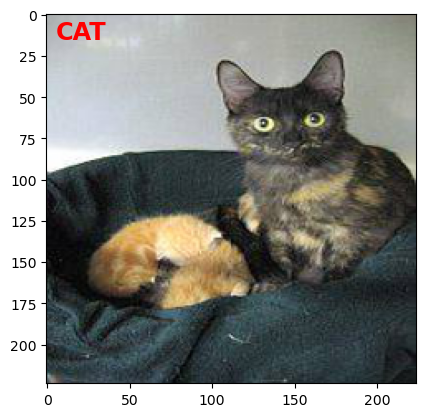

In [20]:
train_test_proportion = .85

samples = glob.glob(os.path.join('./dog-vs-cats/train', '*.jpg'))

train_samples = samples[:int(train_test_proportion * len(samples))]
test_samples = samples[int(train_test_proportion * len(samples)):]

cats_dogs_train = CatsDogsDataset(train_samples, width=224, height=224)
cats_dogs_test = CatsDogsDataset(test_samples, width=224, height=224)

print(cats_dogs_train[0][0].shape)

train_loader_resnet18 = DataLoader(cats_dogs_train, batch_size=16, shuffle=True)
test_loader_resnet18 = DataLoader(cats_dogs_test, batch_size=16, shuffle=False)

print(next(iter(train_loader_resnet18)))

see_examples = 1
for i, (imgs, label) in enumerate(train_loader_resnet18):
    clear_output(wait=True)
    image = imgs[0].numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.text(5, 15, "DOG" if label[0] else "CAT", fontsize='xx-large', color='red', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
        break
    time.sleep(1)

In [23]:
# Definiti numarul de epoci
epochs = 2

# Definiti reteaua
network = resnet18.to(device)

# Definiti optimizatorul
optimizer = optim.SGD(network.parameters(), lr=0.0001)
"""
Dupa definirea optimizatorului si dupa fiecare iteratie de antrenare, trebuie 
apelata functia zero_grad() pentru a seta valoare tuturor gradientilor la zero.
"""
# Completati aici codul pentru seta valoare tuturor gradientilor la zero
optimizer.zero_grad()

# Definiti functia cost pentru clasificare Cross-Entropy
# https://neptune.ai/blog/pytorch-loss-functions
loss_fn = nn.CrossEntropyLoss()

In [24]:
train_fn(epochs, train_loader_resnet18, test_loader_resnet18, network, loss_fn, optimizer)

Loss-ul la finalul epocii 1 are valoarea 0.5835468173027039 si a durat: 61.1s antrenarea
Acuratetea la finalul epocii 1 este 0.00% si a durat 0.1s evaluarea
Loss-ul la finalul epocii 2 are valoarea 0.7630195021629333 si a durat: 61.5s antrenarea
Acuratetea la finalul epocii 2 este 0.00% si a durat 0.1s evaluarea


In [44]:
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
imgs, labels = next(iter(test_loader_resnet18))
imgs, labels = imgs.to(device), labels.to(device)
print(imgs.shape)

output = resnet18(imgs)
print(torch.argmax(output))

# image_array = imgs[5].permute(1, 2, 0).cpu().numpy()
# plt.imshow(image_array)
# plt.show()

torch.Size([64, 3, 224, 224])
tensor(124, device='cuda:0')
